## pain questionnaire based classification dev

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import optuna

In [2]:
import matplotlib.pyplot as plt
from sklearn.metrics import balanced_accuracy_score, roc_auc_score

In [7]:
from compare_painquestion import objective, make_data_painquestion
from compare_hyperparams import load_feats, feature_importance, load_modZ, remove_subjs, load_cv, top_mods
from compare_bfl_qsidp import load_qscode, match_question, proc_qsidp

#### load bigflica data

In [18]:
# df = load_cv(cv_dir)
df = pd.read_csv('cv_results/painquestion/cv_results_30IC_qs.csv')

In [19]:
df.shape

(16, 10)

In [21]:
df.head()

,max_depth,n_estimators,max_features,min_samples_split,min_samples_leaf,max_samples,balanced_accuracy,roc_auc,bestIC,qsidp
0,2,125,0.728446,6,13,0.934649,0.519737,0.518966,30,None
1,2,200,0.870784,4,2,0.742753,0.525743,0.521028,30,['cognitive']
2,2,125,0.464379,9,10,0.745857,0.519895,0.524775,30,['demographic']
3,2,50,0.261917,14,2,0.748072,0.524640,0.525385,30,['lifestyle']
4,2,50,0.393781,2,13,0.636148,0.565920,0.590885,30,['mental']


In [22]:
df.iloc[df['balanced_accuracy'].argmax()]

max_depth                                               3
n_estimators                                           50
max_features                                     0.152889
min_samples_split                                       7
min_samples_leaf                                       14
max_samples                                      0.706131
balanced_accuracy                                0.573985
roc_auc                                          0.600917
bestIC                                                 30
qsidp                ['cognitive', 'lifestyle', 'mental']
Name: 13, dtype: object

In [9]:
df_g = df.groupby(['bestIC', 'qsidp'])['test_roc_auc', 'test_accuracy'].mean().rename(columns={'test_roc_auc':'auc', 'test_accuracy':'acc'})

/gpfs3/well/seymour/users/uhu195/python/extract-py3.7.4-skylake/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


In [10]:
df_g.iloc[df_g['auc'].argmax()]

auc    0.600198
acc    0.571770
Name: (50, ['demographic', 'lifestyle', 'mental']), dtype: float64

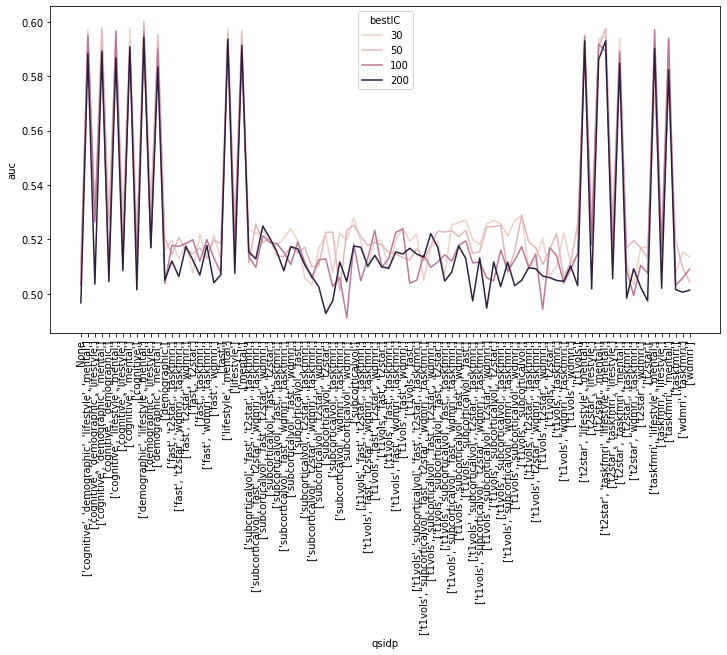

In [12]:
fig, ax = plt.subplots(figsize=(12, 6))
_ = sns.lineplot(data=df_g, x='qsidp', y='auc', hue='bestIC', ax=ax)
_ = plt.xticks(rotation=90)

#### check importance

In [61]:
# bestIC = 50
# qs_ls = ['demographic', 'lifestyle', 'mental']
# idp_ls = None

In [23]:
bestIC = 30
qs_ls = ['cognitive', 'lifestyle', 'mental']
idp_ls = None

In [39]:
bp = df.iloc[df['balanced_accuracy'].argmax()].to_dict()

In [40]:
for i in ['balanced_accuracy', 'roc_auc', 'bestIC', 'qsidp']:
    del bp[i]

In [42]:
bp

{'max_depth': 3,
 'n_estimators': 50,
 'max_features': 0.1528890712229466,
 'min_samples_split': 7,
 'min_samples_leaf': 14,
 'max_samples': 0.7061310128493092}

In [43]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(**bp)

In [51]:
# load bfl
df_bfl_qsidp = make_data_painquestion(bestIC=bestIC, qs_ls=qs_ls, idp_ls=idp_ls)
# retrain params
X_train, y_train, X_valid, y_valid = load_feats(df_bfl_qsidp, test_size=0.25, dummies=False,
                              train=True, balance=True, scaler=True)

/gpfs3/well/seymour/users/uhu195/python/extract-py3.7.4-skylake/lib/python3.7/site-packages/ipykernel_launcher.py:2: DtypeWarning: Columns (863) have mixed types.Specify dtype option on import or set low_memory=False.
  


df_qs_imputed_dum shape=(8776, 269)
df_bfl_qsidp shape=(8776, 301)
(8776, 298)


In [52]:
clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=3, max_features=0.1528890712229466,
                       max_samples=0.7061310128493092, min_samples_leaf=14,
                       min_samples_split=7, n_estimators=50)

In [53]:
preds = clf.predict(X_train)
print(len(preds))
print(balanced_accuracy_score(y_train, preds))
print(sum(y_train==preds)/len(y_train))

4744
0.6045531197301854
0.6045531197301856


In [54]:
preds = clf.predict(X_valid)
print(len(preds))
print(balanced_accuracy_score(y_valid, preds))
print(sum(y_valid==preds)/len(y_valid))

1582
0.5764854614412136
0.5764854614412137


In [55]:
roc_auc_score(y_valid, clf.predict_proba(X_valid)[:,1])

0.6143641887799054

In [56]:
output_ls = ['label', 'eid', 'bmrc']
tmp = df_bfl_qsidp.drop(columns=output_ls)
feature_names = tmp.columns

In [57]:
feat_importances = pd.Series(clf.feature_importances_, index=feature_names)

In [58]:
feat_sorted = feat_importances.sort_values(ascending=False)

Text(0, 0.5, 'Mean decrease in impurity')

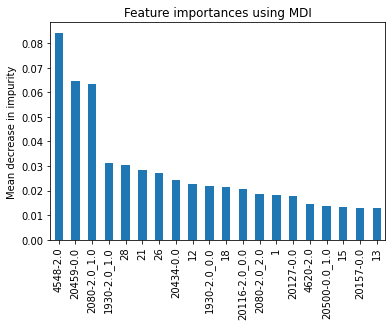

In [59]:
fig, ax = plt.subplots()
feat_sorted.iloc[:20].plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")

In [60]:
feats10 = feat_sorted.iloc[:20].index
match_question(feats10)

[array(['Health satisfaction'], dtype=object),
 array(['General happiness with own health'], dtype=object),
 array(['Frequency of tiredness / lethargy in last 2 weeks'], dtype=object),
 array(['Miserableness'], dtype=object),
 array(['Age at last episode of depression'], dtype=object),
 array(['Miserableness'], dtype=object),
 array(['Smoking status'], dtype=object),
 array(['Frequency of tiredness / lethargy in last 2 weeks'], dtype=object),
 array(['Neuroticism score'], dtype=object),
 array(['Number of depression episodes'], dtype=object),
 array(['Ever suffered mental distress preventing usual activities'],
       dtype=object),
 array(['Duration to complete alphanumeric path (trail #2)'], dtype=object)]

#### visualising top feature

In [61]:
# data_dir = '/well/tracey/shared/fps-ukb/bigflica_output/output_painquestion_500/Result_IC50/'
data_dir = '/well/tracey/shared/fps-ukb/bigflica_output/output_painquestion_500/Result_IC30/'

In [62]:
def top_mods(data_dir, top_feat, mod_num=3, plot=True):
    """return top modalities given feature importance"""
    mod_contrib = np.load(os.path.join(data_dir, 'mod_contribution.npy')) # mod x feats
#     top_feat = int(feature_importance.index[0].split(' ')[1])
    print(f'top feature: {top_feat}')
    topIC = mod_contrib[:,top_feat]
    # load mod names
    mod_names = pd.read_csv('./sorted_feats.csv')
    plot_mod = mod_names.iloc[topIC.argsort()]
#     print(plot_mod.index.max())
    print('top modalities', plot_mod.iloc[-mod_num:])
    if plot:
        import matplotlib.pyplot as plt
        plt.subplots(figsize=(8,4))
        plt.bar(np.arange(len(topIC)), topIC[topIC.argsort()])
        plot_mod_names = plot_mod['modalities'].values
        plt.xticks(np.arange(len(plot_mod_names)), plot_mod_names, rotation=90)
    return top_feat, plot_mod.index[-mod_num:].values[::-1]

top feature: 28
top modalities                   modalities
9   T1_GM_to_template_GM_mod
8                     zstat1
34                     cope2
44                     cope1
29             T2star_to_MNI


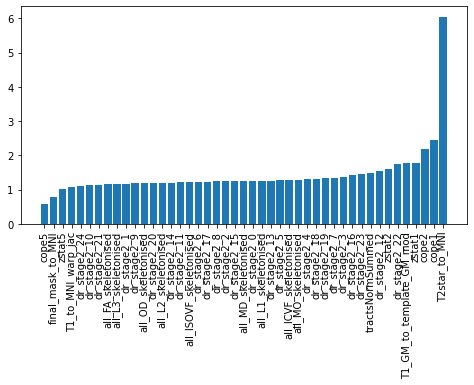

In [63]:
top_feat, mod_ls = top_mods(data_dir, top_feat=28, mod_num=5)

modality 29
(1827095, 30)
modality 44
(228453, 30)
modality 34
(228453, 30)
modality 8
(228453, 30)
modality 9
(228453, 30)


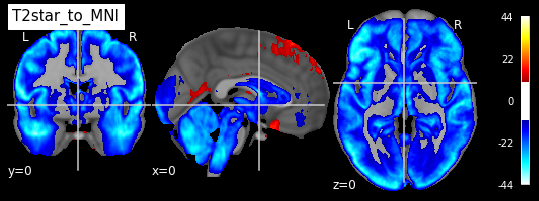

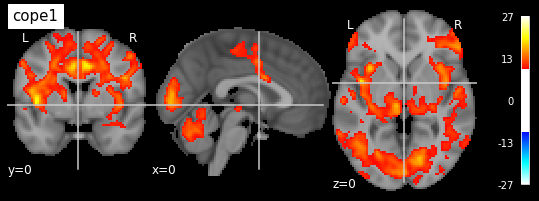

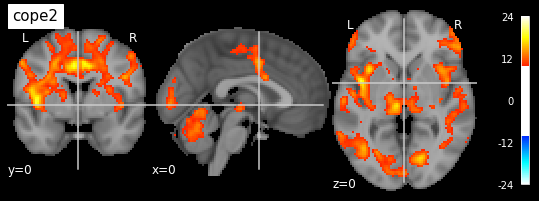

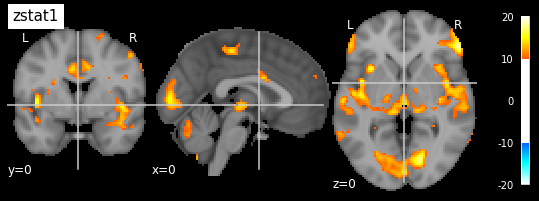

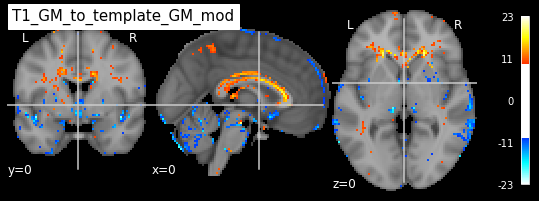

In [66]:
for mod in mod_ls:
    print(f'modality {mod}')
    reshape_z, mask_path = load_modZ(data_dir, modality_num=mod, feature_num=top_feat, plot_threshold=10)

top feature: 21
top modalities                   modalities
34                     cope2
9   T1_GM_to_template_GM_mod
44                     cope1
40                    zstat2
8                     zstat1


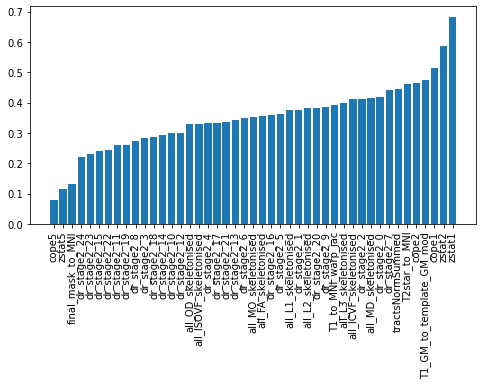

In [67]:
top_feat, mod_ls = top_mods(data_dir, top_feat=21, mod_num=5)

modality 8
(228453, 30)
modality 40
(228453, 30)
modality 44
(228453, 30)
modality 9
(228453, 30)
modality 34
(228453, 30)


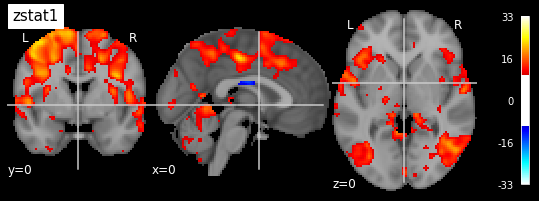

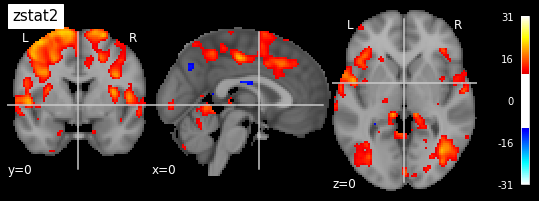

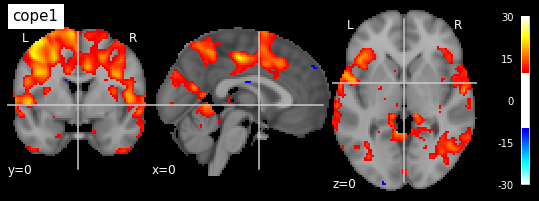

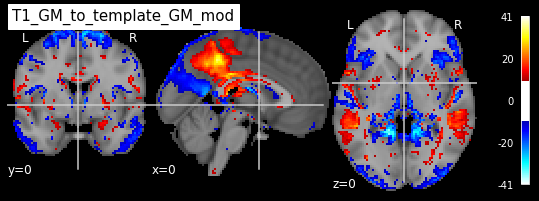

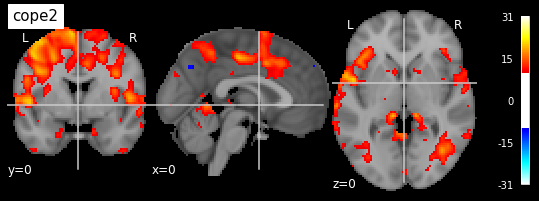

In [69]:
for mod in mod_ls:
    print(f'modality {mod}')
    reshape_z, mask_path = load_modZ(data_dir, modality_num=mod, feature_num=top_feat, plot_threshold=10)